Install Packages!!! I'm tired!!!!

In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy scipy scikit-image einops tqdm


Imports!!!!!

In [ ]:
import math, os, random, time
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Datset Generation Functions!!!

In [ ]:
def generate_heat_solution(x, t, modes=[(1.0,1)], alpha=0.1):
    # u(x,t) = sum A_n sin(n*pi*x) * exp(-alpha * (n*pi)^2 * t)
    u = np.zeros((len(t), len(x)))
    for A, n in modes:
        u += A * np.sin(n * np.pi * x)[None, :] * np.exp(-alpha * (n*np.pi)**2 * t)[:, None]
    return u

def generate_wave_solution(x, t, modes=[(1.0,1)], c=1.0):
    # u(x,t) = sum A_n sin(n*pi*x) * cos(c*n*pi*t)
    u = np.zeros((len(t), len(x)))
    ut = np.zeros_like(u)
    for A, n in modes:
        u += A * np.sin(n * np.pi * x)[None, :] * np.cos(c * n * np.pi * t)[:, None]
        ut += -A * np.sin(n * np.pi * x)[None, :] * (c*n*np.pi) * np.sin(c * n * np.pi * t)[:, None]
    return u, ut

# multilingual prompt mapping (a small controlled vocabulary)
# tied synonyms across languages to same canonical token ID to simulate multilingual understanding.
translation_map = {
    "heat": ["heat equation", "ecuación de calor", "Waermeleitungsgleichung", "εξίσωση θερμότητας"],
    "wave": ["wave equation", "ecuación de onda", "Wellengleichung", "εξίσωση κύματος"],
    "dirichlet": ["Dirichlet", "Dirichlet", "Dirichlet", "Dirichlet"],
    "neumann": ["Neumann", "Neumann", "Neumann", "Neumann"],
    "solve": ["solve", "resuelve", "loese", "λύσε"],
}

languages = ["en", "es", "de", "el"]

# build tokens: map tokens to canonical keys, then to ids
token_to_key = {}
for key, phrases in translation_map.items():
    for phrase in phrases:
        token_to_key[phrase.lower()] = key

# small tokenizer: split prompt by spaces, use mapping
def prompt_to_tokens(prompt):
    words = prompt.lower().split()
    keys = [token_to_key.get(" ".join(words[i:i+2]), None) for i in range(len(words))]  # try bigrams
    # fallback to unigrams
    for i,k in enumerate(keys):
        if k is None:
            words_i = words[i].strip()
            keys[i] = token_to_key.get(words_i, words_i)
    keys = [k for k in keys if k is not None]
    return keys

# vocabulary and assign ids such that multilingual synonyms share the same id (via canonical key)
vocab = {}
next_id = 0
for phrase, key in token_to_key.items():
    if key not in vocab:
        vocab[key] = next_id
        next_id += 1

# and a few generic tokens
for extra in ["with", "conditions", "initial", "boundary", "dirichlet", "neumann", "solve"]:
    if extra not in vocab:
        vocab[extra] = next_id; next_id += 1

id_to_token = {v:k for k,v in vocab.items()}
vocab_size = len(vocab)
print("Vocab size:", vocab_size, "Sample mapping:", list(vocab.items())[:10])

class PDESolutionsDataset(Dataset):
    def __init__(self, N_samples=500, nx=64, nt=64):
        self.N = N_samples
        self.nx = nx
        self.nt = nt
        self.x = np.linspace(0,1,nx)
        self.t = np.linspace(0,1,nt)
        self.samples = []
        for i in range(self.N):
            pde_type = random.choice(["heat", "wave"])
            if pde_type == "heat":
                # random superposition of a few sine modes
                nmodes = random.randint(1,3)
                modes = [(random.uniform(0.5,1.5), random.randint(1,4)) for _ in range(nmodes)]
                u = generate_heat_solution(self.x, self.t, modes=modes, alpha=random.uniform(0.05,0.3))
                # pack as single-channel image (nt x nx)
                grid = u.astype(np.float32)
                # generate a multilingual prompt
                lang = random.choice(languages)
                phrase = {
                    "en": f"solve heat equation with Dirichlet",
                    "es": f"resuelve ecuación de calor con Dirichlet",
                    "de": f"loese Waermeleitungsgleichung mit Dirichlet",
                    "el": f"λύσε εξίσωση θερμότητας με Dirichlet"
                }[lang]
                prompt = phrase
            else:
                nmodes = random.randint(1,3)
                modes = [(random.uniform(0.5,1.5), random.randint(1,4)) for _ in range(nmodes)]
                u, ut = generate_wave_solution(self.x, self.t, modes=modes, c=random.uniform(0.8,1.2))
                grid = u.astype(np.float32)
                lang = random.choice(languages)
                phrase = {
                    "en": f"solve wave equation with Dirichlet",
                    "es": f"resuelve ecuación de onda con Dirichlet",
                    "de": f"loese Wellengleichung mit Dirichlet",
                    "el": f"λύσε εξίσωση κύματος με Dirichlet"
                }[lang]
                prompt = phrase
            tokens_keys = prompt_to_tokens(prompt)
            token_ids = [vocab.get(k, 0) for k in tokens_keys]  # fallback to 0
            self.samples.append({
                "grid": grid,           # (nt, nx)
                "pde": pde_type,
                "prompt": prompt,
                "token_ids": token_ids
            })
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        s = self.samples[idx]
        # normalize grid to [-1,1] for network
        g = s["grid"]
        g = (g - g.mean()) / (g.std()+1e-8)
        return torch.from_numpy(g)[None, ...], s["token_ids"], s["pde"]


Vocab size: 9 Sample mapping: [('heat', 0), ('wave', 1), ('dirichlet', 2), ('neumann', 3), ('solve', 4), ('with', 5), ('conditions', 6), ('initial', 7), ('boundary', 8)]


VAE Model!!

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, in_ch=1, z_dim=64):
        super().__init__()
        self.z_dim = z_dim
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU()
        )
        self.flatten = nn.Flatten()
        # compute conv output shape for small input (nt=64,nx=64) => downsample 8x -> 8x8 maps of 64
        conv_out_dim = 64 * 8 * 8
        self.fc_mu = nn.Linear(conv_out_dim, z_dim)
        self.fc_logvar = nn.Linear(conv_out_dim, z_dim)
        # decoder
        self.fc_dec = nn.Linear(z_dim, conv_out_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, in_ch, 4, stride=2, padding=1),  # back to 64x64
        )
    def encode(self, x):
        h = self.enc(x)
        h_flat = self.flatten(h)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, 8, 8)
        xrec = self.dec(h)
        return xrec
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xr = self.decode(z)
        return xr, mu, logvar

# small VAE trainer (few epochs)
def train_vae(vae, dataloader, epochs=6, lr=1e-3):
    vae.to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=lr)
    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for xb, _, _ in dataloader:
            xb = xb.to(device)
            xr, mu, logvar = vae(xb)
            recon_loss = F.mse_loss(xr, xb)
            kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + 1e-3 * kld
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * xb.size(0)
        print(f"VAE Epoch {epoch+1}/{epochs} loss: {total_loss/len(dataloader.dataset):.6f}")
    return vae


Multilingual Text Encoder (learned token embeddings and pooling)

In [ ]:
class TinyTextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
    def forward(self, token_ids_batch):
        # token_ids_batch: list of lists (variable lengths)
        maxlen = max(len(x) for x in token_ids_batch)
        padded = [x + [0]*(maxlen-len(x)) for x in token_ids_batch]
        ids = torch.tensor(padded, dtype=torch.long, device=device)
        e = self.emb(ids)  # (B, L, E)
        e = e.mean(dim=1)  # simple mean pooling -> (B, E)
        return e

text_enc = TinyTextEncoder(vocab_size=vocab_size, emb_dim=64).to(device)


Laten DDPM simpliffied (MLP denoiser)

In [ ]:
class LatentDenoiser(nn.Module):
    def __init__(self, z_dim=64, cond_dim=64, hidden=256):
        super().__init__()
        # input: z_noisy (z_dim), timestep scalar, cond embedding (cond_dim)
        self.net = nn.Sequential(
            nn.Linear(z_dim + cond_dim + 1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, z_dim)
        )
    def forward(self, z_noisy, t, cond):
        # z_noisy: (B,z), t: (B,) float or int, cond: (B,cond_dim)
        t = t.float().unsqueeze(1) / 1000.0
        inp = torch.cat([z_noisy, cond, t], dim=1)
        return self.net(inp)

# noise schedule utilities
def linear_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

T = 100  # small diffusion timesteps
betas = linear_beta_schedule(T).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# training objective: predict noise eps
def q_sample(z0, t, noise):
    # z0: (B,z), t: (B,) indices
    a = alphas_cumprod[t].unsqueeze(1)  # (B,1)
    return torch.sqrt(a) * z0 + torch.sqrt(1-a) * noise

def train_diffusion(denoiser, vae, text_enc, dataloader, epochs=8, lr=1e-4):
    denoiser.to(device)
    vae.to(device)
    text_enc.to(device)
    opt = torch.optim.Adam(list(denoiser.parameters()) + list(text_enc.parameters()), lr=lr)
    mse = nn.MSELoss()
    for epoch in range(epochs):
        denoiser.train()
        total_loss = 0
        for xb, token_ids_batch, _ in dataloader:
            xb = xb.to(device)
            # encode to latent (use encoder mu as deterministic latent for simplicity)
            with torch.no_grad():
                mu, logvar = vae.encode(xb)
                z0 = mu  # (B,z)
            B = z0.size(0)
            t = torch.randint(0, T, (B,), device=device)
            noise = torch.randn_like(z0)
            z_noisy = q_sample(z0, t, noise)
            cond = text_enc(token_ids_batch)  # (B, cond_dim)
            pred_noise = denoiser(z_noisy, t, cond)
            loss = mse(pred_noise, noise)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * B
        print(f"Diffusion Epoch {epoch+1}/{epochs} loss: {total_loss/len(dataloader.dataset):.6f}")
    return denoiser, text_enc
    # gotta take a dump...


Sampling (DDPM ancestral from pure noise) in latent space

In [ ]:
@torch.no_grad()
def sample_conditioned(denoiser, text_enc, vae, prompt_token_ids, n_steps=T):
    denoiser.eval(); text_enc.eval(); vae.eval()
    B = len(prompt_token_ids)
    cond = text_enc(prompt_token_ids)  # (B, cond_dim)
    z = torch.randn(B, vae.z_dim, device=device)
    for t in reversed(range(n_steps)):
        t_batch = torch.tensor([t]*B, device=device)
        # predict noise
        pred_noise = denoiser(z, t_batch, cond)
        a_t = alphas[t]
        a_cum = alphas_cumprod[t]
        if t > 0:
            beta_t = betas[t]
            z = (1.0 / torch.sqrt(a_t)) * (z - (beta_t / torch.sqrt(1 - a_cum)) * pred_noise) + torch.sqrt(beta_t) * torch.randn_like(z)
        else:
            z = (1.0 / torch.sqrt(a_t)) * (z - (beta_t / torch.sqrt(1 - a_cum)) * pred_noise)
    # decode
    xr = vae.decode(z).cpu().numpy()
    return xr, z.cpu().numpy()

# plotting helper (grid -> heatmap)
def plot_solution_grid(grid, title=None, cmap="viridis"):
    plt.figure(figsize=(4,4))
    if grid.ndim == 3:
        img = grid[0]  # assume (1,nt,nx)
    else:
        img = grid
    plt.imshow(img, aspect='auto', origin='lower')
    plt.colorbar()
    if title: plt.title(title)
    plt.xlabel("x")
    plt.ylabel("t")

# phase portrait for wave: u vs ut at a chosen x index
def phase_portrait(u_grid, ut_grid, x_idx=None):
    nt, nx = u_grid.shape
    if x_idx is None:
        x_idx = nx//2
    u = u_grid[:, x_idx]
    ut = ut_grid[:, x_idx]
    plt.figure(figsize=(4,4))
    plt.plot(u, ut, '-o', markersize=2)
    plt.xlabel("u")
    plt.ylabel("u_t")
    plt.title("Phase portrait (at x ~ center)")


Metrics, brother!!

In [ ]:

def compute_mse(gt, pred):
    return float(((gt - pred)**2).mean())

def pde_residual_heat(u_grid, x, t, alpha=0.1):
    """
    Compute PDE residual for the heat equation:
        R = u_t - alpha * u_xx
    using central finite differences, properly aligned to avoid shape mismatches.
    """
    nt, nx = u_grid.shape
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # central differences in time and space
    u_t = (u_grid[2:, :] - u_grid[:-2, :]) / (2 * dt)           # shape (nt-2, nx)
    u_xx = (u_grid[:, 2:] - 2 * u_grid[:, 1:-1] + u_grid[:, :-2]) / (dx**2)  # shape (nt, nx-2)

    # align shapes: crop both in time and space to match
    u_t = u_t[:, 1:-1]       # (nt-2, nx-2)
    u_xx = u_xx[1:-1, :]     # (nt-2, nx-2)

    res = u_t - alpha * u_xx
    return float(np.mean(np.abs(res)))


def conservation_mass(u_grid, x):
    # approximate integral over space for each t, measure relative change
    dx = x[1]-x[0]
    mass = u_grid.sum(axis=1) * dx
    return float(np.std(mass) / (np.mean(np.abs(mass))+1e-8))

# symbolic fit for 1D sine basis on x for each t to recover coefficients (approx)
def symbolic_sine_fit(u_grid, x, n_basis=6):
    # fit u(x,t) = sum c_n(t) sin(n*pi*x)
    X = []
    for n in range(1, n_basis+1):
        X.append(np.sin(n * np.pi * x))
    X = np.stack(X, axis=1)  # (nx, n_basis)
    coeffs = np.linalg.lstsq(X, u_grid.T, rcond=None)[0]  # (n_basis, nt)
    return coeffs  # each column corresponds to t


full pipeline with dataloder batching for variable-length tokens...

Training VAE...
VAE Epoch 1/50 loss: 0.771615
VAE Epoch 2/50 loss: 0.320405
VAE Epoch 3/50 loss: 0.111000
VAE Epoch 4/50 loss: 0.064551
VAE Epoch 5/50 loss: 0.045846
VAE Epoch 6/50 loss: 0.033364
VAE Epoch 7/50 loss: 0.025218
VAE Epoch 8/50 loss: 0.019171
VAE Epoch 9/50 loss: 0.015157
VAE Epoch 10/50 loss: 0.012786
VAE Epoch 11/50 loss: 0.011850
VAE Epoch 12/50 loss: 0.010877
VAE Epoch 13/50 loss: 0.010033
VAE Epoch 14/50 loss: 0.011458
VAE Epoch 15/50 loss: 0.011864
VAE Epoch 16/50 loss: 0.010137
VAE Epoch 17/50 loss: 0.009094
VAE Epoch 18/50 loss: 0.008701
VAE Epoch 19/50 loss: 0.010498
VAE Epoch 20/50 loss: 0.009151
VAE Epoch 21/50 loss: 0.007998
VAE Epoch 22/50 loss: 0.007665
VAE Epoch 23/50 loss: 0.007402
VAE Epoch 24/50 loss: 0.006825
VAE Epoch 25/50 loss: 0.006674
VAE Epoch 26/50 loss: 0.006625
VAE Epoch 27/50 loss: 0.006230
VAE Epoch 28/50 loss: 0.007099
VAE Epoch 29/50 loss: 0.007626
VAE Epoch 30/50 loss: 0.006880
VAE Epoch 31/50 loss: 0.006281
VAE Epoch 32/50 loss: 0.006162
V

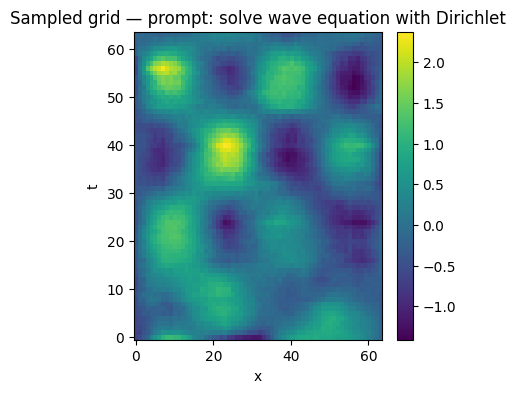

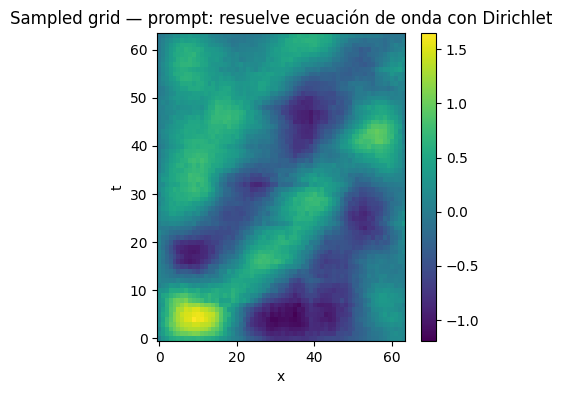

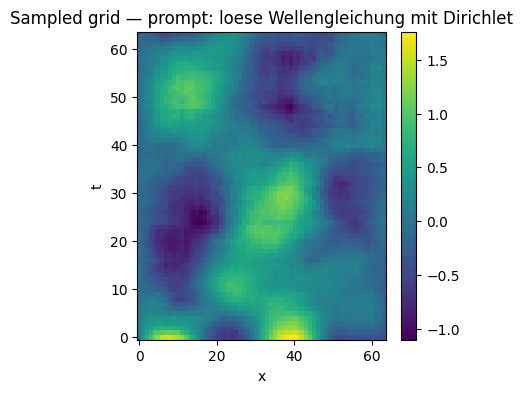

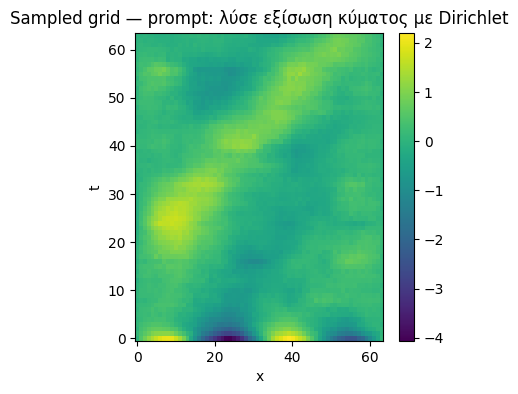

Evaluating metrics on held-out subset...
Mean MSE (VAE recon): 0.0018607129022711888
Mean PDE residual (approx): 27.094453209742134
Mean conservation metric (std/mean): 0.9202773986499266


In [ ]:

#c ustom collate function
def collate_fn(batch):
    xs, tokens, pdes = zip(*batch)
    xs = torch.stack(xs, dim=0)           # stack the 3D tensors (B,1,nt,nx)
    return xs, list(tokens), list(pdes)

# build dataset and dataloader
ds = PDESolutionsDataset(N_samples=300, nx=64, nt=64)
dl = DataLoader(ds, batch_size=16, shuffle=True, drop_last=True, collate_fn=collate_fn)

# train VAE
vae = ConvVAE(in_ch=1, z_dim=128)
print("Training VAE...")
vae = train_vae(vae, dl, epochs=50, lr=2e-3)

# train latent diffusion model
denoiser = LatentDenoiser(z_dim=vae.z_dim, cond_dim=64, hidden=256)
print("Training latent diffusion model...")
denoiser, text_enc = train_diffusion(denoiser, vae, text_enc, dl, epochs=50, lr=1e-4)

# sample a few multilingual prompts
prompts = [
    "solve wave equation with Dirichlet",          # English
    "resuelve ecuación de onda con Dirichlet",     # Spanish
    "loese Wellengleichung mit Dirichlet",         # German
    "λύσε εξίσωση κύματος με Dirichlet"            # Greek
]
token_batches = [[vocab.get(k, 0) for k in prompt_to_tokens(p)] for p in prompts]

# generate samples
print("Sampling conditioned outputs...")
xr, zsamples = sample_conditioned(denoiser, text_enc, vae, token_batches, n_steps=T)

# visualize
for i, p in enumerate(prompts):
    grid = xr[i, 0]
    plot_solution_grid(grid, title=f"Sampled grid — prompt: {p}")
    plt.show()

# evaluation dataset and dataloader
eval_ds = PDESolutionsDataset(N_samples=40, nx=64, nt=64)
eval_dl = DataLoader(eval_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

# compute metrics
mse_list, residual_list, cons_list = [], [], []
x = eval_ds.x; t = eval_ds.t

with torch.no_grad():
    for xb, token_ids_batch, pdes in eval_dl:
        xb = xb.to(device)
        mu, logvar = vae.encode(xb)
        z = mu
        xr_rec = vae.decode(z).cpu().numpy()
        xb_np = xb.cpu().numpy()
        for k in range(xr_rec.shape[0]):
            gt = xb_np[k, 0]   # (nt,nx)
            pred = xr_rec[k, 0]
            mse_list.append(compute_mse(gt, pred))
            if eval_ds.samples[k]["pde"] == "heat":
                residual_list.append(pde_residual_heat(gt, x, t, alpha=0.1))
                cons_list.append(conservation_mass(gt, x))
            else:
                u = gt
                dt = t[1]-t[0]; dx = x[1]-x[0]
                u_tt = (u[2:,:] - 2*u[1:-1,:] + u[:-2,:]) / (dt**2)
                u_xx = (u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,:-2]) / (dx**2)
                rr = np.abs(u_tt[:,1:-1] - u_xx).mean()
                residual_list.append(float(rr))
                cons_list.append(conservation_mass(gt, x))

print("Mean MSE (VAE recon):", np.mean(mse_list))
print("Mean PDE residual (approx):", np.mean(residual_list))
print("Mean conservation metric (std/mean):", np.mean(cons_list))
